In [1]:
using RCall, Distributions, Gadfly, PyPlot, LowRankApprox

In [135]:
R"
library(alstructure)
m = 4000 # number of SNPS
n = 400 # number of individuals
d = 3 # dimension of latent subspace
alpha = c(.2, .2, .2) # dirichlet parameters
seed = 100
sim_data = simulate_admixture(m, n, d, alpha, BN_params = NA, seed = seed)
X = sim_data$X;
P_true = t(sim_data$P); Q_true = t(sim_data$Q);
";
@rget P_true; @rget Q_true;

In [136]:
R"
fit = alstructure(X = X, d_hat = 3);
Q_als = fit$Q_hat;
P_als = fit$P_hat
";
@rget P_als; @rget Q_als; P_als = P_als'; Q_als = Q_als';

In [155]:
# for mathematical derivation, see the note below.

include("../src/ASH_functions.jl"); include("../src/mixsqp.jl")

function update_π(X, π, μ, τ; t = 1.2.^(-(1:10) + 1) - 1)
    
    # construct Y
    η = π * μ;
    η[η .> 0.5] = 1 - η[η .> 0.5];
    Y = π .* ((X .* τ ./ η) * μ' + ((2 - X) .* τ ./ (1 - η)) * (1-μ)')
    
    # solve empirical Bayes normal means problem
    out = ash_dirichlet(Y,h_diff_dirichlet; t = t)
    
    return out[:pm]
end

function update_π2(X, π, μ, τ; t = 1.2.^(-(1:10) + 1) - 1)
    
    # construct Y
    Y = π .* ((X .* τ) * μ' + ((2 - X) .* τ) * (1 - μ'))
    
    # solve empirical Bayes normal means problem
    out = ash_dirichlet(Y,h_diff_dirichlet; t = t)
    
    return out[:pm]
end


function update_μ(X, π, μ, τ; ν = [zeros(7);ones(5)], t = [2.0.^(-3:3);2.0.^(-2:2)])
    
    # construct ξ and Y
    η = π * μ;
    ξ = (1 - μ) .* (π' * (τ ./ η))
    Y = (1 - μ) .* μ ./ ξ .* (π' * (X .* τ ./ η ./ (1 - η)))
    
    # solve empirical Bayes normal means problem
    out = ash_beta_binomial(Y[:],ξ[:],h_diff_beta; ν = ν, t = t)
    
    return reshape(out[:pm],size(Y))
end

function update_μ2(X, π, μ, τ; ν = [zeros(7);ones(5)], t = [2.0.^(-3:3);2.0.^(-2:2)])
    
    # construct ξ and Y
    C = μ .* (π' * (X .* τ))
    D = (1 - μ) .* (π' * ((2 - X) .* τ))
    ξ = (C+D)/2;
    Y = C ./ ξ;
    
    # solve empirical Bayes normal means problem
    out = ash_beta_binomial(Y[:],ξ[:],h_diff_beta; ν = ν, t = t)
    
    return reshape(out[:pm],size(Y))
end

function update_τ(X, π, μ)
    
    η = π * μ;
    τ = 2 * mean(η,1) .* (1 - mean(η,1)) ./ mean((X .- 2 * η).^2,1)
    
    return τ
end

update_τ (generic function with 1 method)

In [184]:
R"
library(alstructure)
m = 4000 # number of SNPS
n = 400 # number of individuals
d = 3 # dimension of latent subspace
alpha = c(.2, .2, .2) # dirichlet parameters
seed = 1
sim_data = simulate_admixture(m, n, d, alpha, BN_params = NA, seed = seed)
X = sim_data$X;
P_true = t(sim_data$P); Q_true = t(sim_data$Q);
fit = alstructure(X = X, d_hat = 3);
Q_als = t(fit$Q_hat);
P_als = t(fit$P_hat)
init = alstructure(X = X, d_hat = 3, max_iters = 50)
Q = t(init$Q_hat);
P = t(init$P_hat);
"
@rget P_true; @rget Q_true; @rget P_als; @rget Q_als; @rget P; @rget Q;
@rget X; X = X'; n = size(X,1);

In [185]:
hwind = find((sum(X,1) .< 2) .| (sum(X,1) .> 2*n-4))
ind = find((sum(X,1) .> 1) .& (sum(X,1) .< 2*n-2))
X2 = X[:,ind];
π = copy(Q); μ = copy(P[:,ind]); τ = update_τ(X2, π, μ);
η = π * μ;
τ = update_τ(X2, π, μ)
#τ = ones(1,p2)
for i = 1:30
    π_old = copy(π); μ_old = copy(μ);
    π = update_π(X2, π, μ, τ)
    μ = update_μ2(X2, π, μ, τ)
    τ = update_τ(X2, π, μ)
    diff = vecnorm(π - π_old) + vecnorm(μ - μ_old);
    if diff < .5
        break;
    end
    if rem(i,10) == 0
        println("$i-th iteration: diff = $diff")
    end
end

10-th iteration: diff = 0.786877763499763


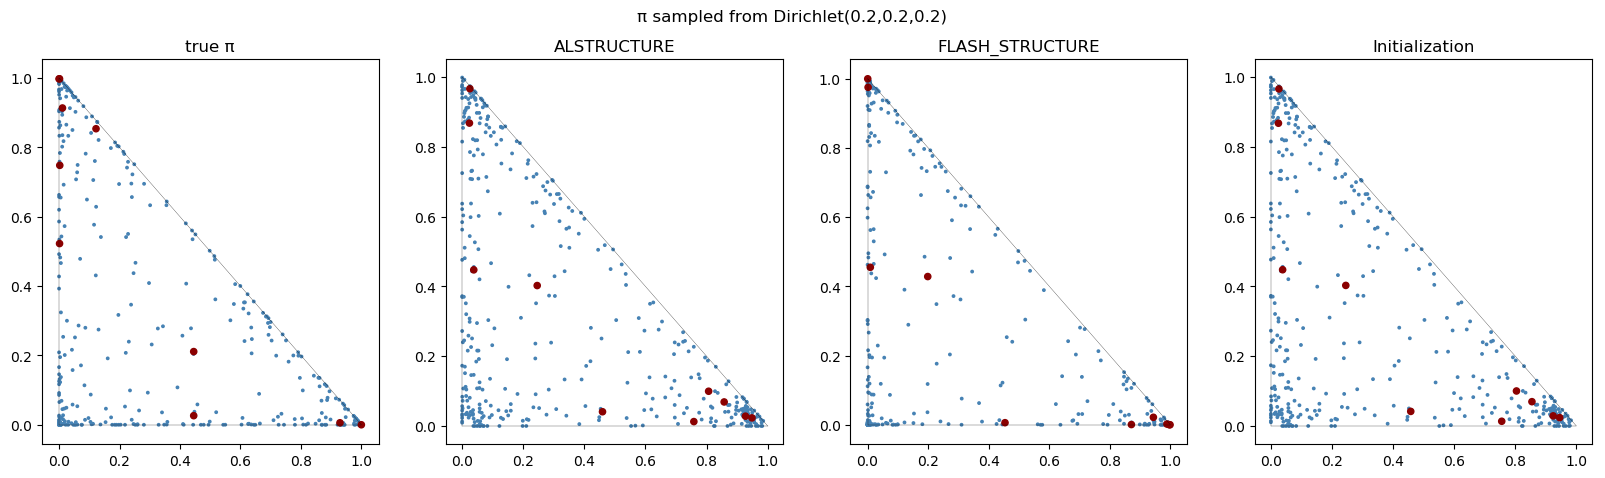

PyObject Text(0.5,0.98,u'\u03c0 sampled from Dirichlet(0.2,0.2,0.2)')

In [186]:
ind = n+1 - (1:10)
col = repeat([:steelblue],inner = n)
siz = 3 * ones(n)
siz[ind] = 20;
col[ind] = :darkred;

ax, fig = subplots(figsize = (20,5))
subplot(141)
PyPlot.scatter(Q_true[:,3],Q_true[:,2], s = siz, c = col);
PyPlot.plot((0,0),(0,1), c = :black, linewidth = 0.2);
PyPlot.plot((1,0),(0,0), c = :black, linewidth = 0.2);
PyPlot.plot((0,1),(1,0), c = :black, linewidth = 0.2);
PyPlot.title("true π")
subplot(142)
PyPlot.scatter(Q_als[:,1],Q_als[:,2], s = siz, c = col);
PyPlot.plot((0,0),(0,1), c = :black, linewidth = 0.2);
PyPlot.plot((1,0),(0,0), c = :black, linewidth = 0.2);
PyPlot.plot((0,1),(1,0), c = :black, linewidth = 0.2);
PyPlot.title("ALSTRUCTURE")
subplot(143)
PyPlot.scatter(π[:,1],π[:,2], s = siz, c = col);
PyPlot.plot((0,0),(0,1), c = :black, linewidth = 0.2);
PyPlot.plot((1,0),(0,0), c = :black, linewidth = 0.2);
PyPlot.plot((0,1),(1,0), c = :black, linewidth = 0.2);
PyPlot.title("FLASH_STRUCTURE")
subplot(144)
PyPlot.scatter(Q[:,1],Q[:,2], s = siz, c = col);
PyPlot.plot((0,0),(0,1), c = :black, linewidth = 0.2);
PyPlot.plot((1,0),(0,0), c = :black, linewidth = 0.2);
PyPlot.plot((0,1),(1,0), c = :black, linewidth = 0.2);
PyPlot.title("Initialization")

suptitle("π sampled from Dirichlet(0.2,0.2,0.2)");

In [164]:
R"
library(alstructure)
m = 4000 # number of SNPS
n = 400 # number of individuals
d = 3 # dimension of latent subspace
alpha = c(.1, .5, 1) # dirichlet parameters
seed = 100
sim_data = simulate_admixture(m, n, d, alpha, BN_params = NA, seed = seed)
X = sim_data$X;
P_true = t(sim_data$P); Q_true = t(sim_data$Q);
fit = alstructure(X = X, d_hat = 3);
Q_als = t(fit$Q_hat);
P_als = t(fit$P_hat)
init = alstructure(X = X, d_hat = 3, max_iters = 50)
Q = t(init$Q_hat);
P = t(init$P_hat);
"
@rget P_true; @rget Q_true; @rget P_als; @rget Q_als; @rget P; @rget Q;
@rget X; X = X'; n = size(X,1);

In [172]:
hwind = find((sum(X,1) .< 2) .| (sum(X,1) .> 2*n-4))
ind = find((sum(X,1) .> 1) .& (sum(X,1) .< 2*n-2))
X2 = X[:,ind];
π = copy(Q); μ = copy(P[:,ind]); τ = update_τ(X2, π, μ);
η = π * μ;
τ = update_τ(X2, π, μ)
#τ = ones(1,p2)
for i = 1:30
    π_old = copy(π); μ_old = copy(μ);
    π = update_π(X2, π, μ, τ)
    μ = update_μ2(X2, π, μ, τ)
    τ = update_τ(X2, π, μ)
    diff = vecnorm(π - π_old) + vecnorm(μ - μ_old);
    if diff < .5
        break;
    end
    if rem(i,10) == 0
        println("$i-th iteration: diff = $diff")
    end
end

10-th iteration: diff = 0.9564569232129478
20-th iteration: diff = 0.70420903588436
30-th iteration: diff = 0.7063011731075641


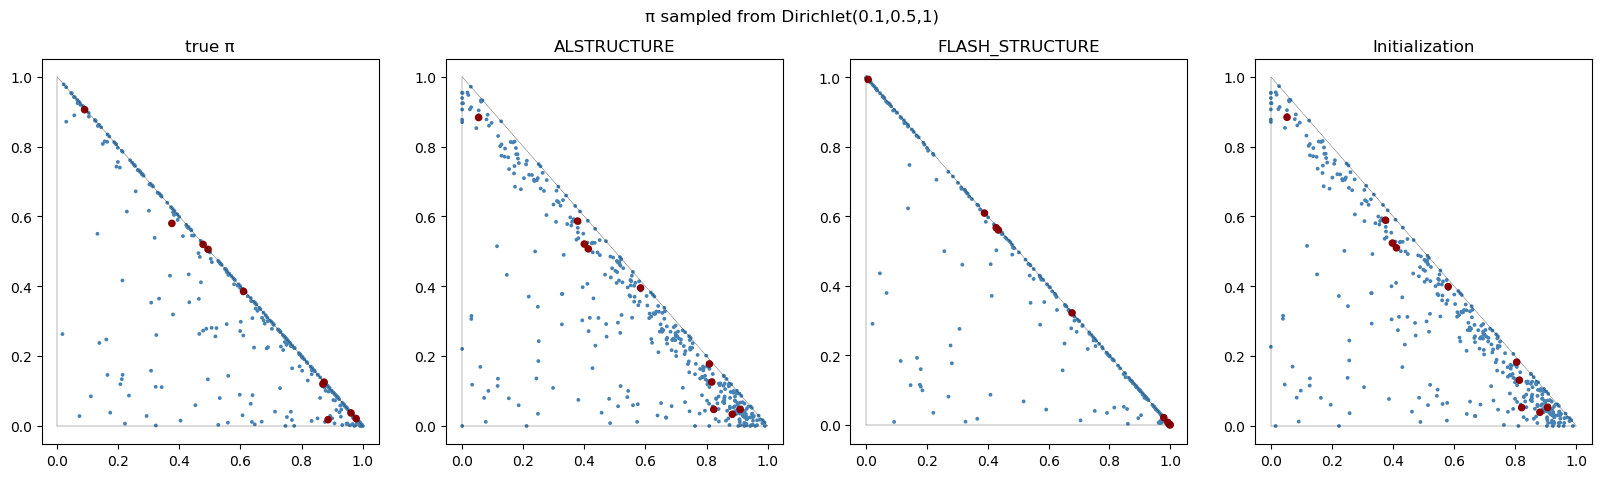

PyObject Text(0.5,0.98,u'\u03c0 sampled from Dirichlet(0.1,0.5,1)')

In [180]:
ind = n+1 - (1:10)
col = repeat([:steelblue],inner = n)
siz = 3 * ones(n)
siz[ind] = 20;
col[ind] = :darkred;

ax, fig = subplots(figsize = (20,5))
subplot(141)
PyPlot.scatter(Q_true[:,3],Q_true[:,2], s = siz, c = col);
PyPlot.plot((0,0),(0,1), c = :black, linewidth = 0.2);
PyPlot.plot((1,0),(0,0), c = :black, linewidth = 0.2);
PyPlot.plot((0,1),(1,0), c = :black, linewidth = 0.2);
PyPlot.title("true π")
subplot(142)
PyPlot.scatter(Q_als[:,1],Q_als[:,2], s = siz, c = col);
PyPlot.plot((0,0),(0,1), c = :black, linewidth = 0.2);
PyPlot.plot((1,0),(0,0), c = :black, linewidth = 0.2);
PyPlot.plot((0,1),(1,0), c = :black, linewidth = 0.2);
PyPlot.title("ALSTRUCTURE")
subplot(143)
PyPlot.scatter(π[:,1],π[:,2], s = siz, c = col);
PyPlot.plot((0,0),(0,1), c = :black, linewidth = 0.2);
PyPlot.plot((1,0),(0,0), c = :black, linewidth = 0.2);
PyPlot.plot((0,1),(1,0), c = :black, linewidth = 0.2);
PyPlot.title("FLASH_STRUCTURE")
subplot(144)
PyPlot.scatter(Q[:,1],Q[:,2], s = siz, c = col);
PyPlot.plot((0,0),(0,1), c = :black, linewidth = 0.2);
PyPlot.plot((1,0),(0,0), c = :black, linewidth = 0.2);
PyPlot.plot((0,1),(1,0), c = :black, linewidth = 0.2);
PyPlot.title("Initialization")

suptitle("π sampled from Dirichlet(0.1,0.5,1)")

In [187]:
R"
library(alstructure)
m = 4000 # number of SNPS
n = 400 # number of individuals
d = 3 # dimension of latent subspace
alpha = c(1, 1, 1) # dirichlet parameters
seed = 100
sim_data = simulate_admixture(m, n, d, alpha, BN_params = NA, seed = seed)
X = sim_data$X;
P_true = t(sim_data$P); Q_true = t(sim_data$Q);
fit = alstructure(X = X, d_hat = 3);
Q_als = t(fit$Q_hat);
P_als = t(fit$P_hat)
init = alstructure(X = X, d_hat = 3, max_iters = 50)
Q = t(init$Q_hat);
P = t(init$P_hat);
"
@rget P_true; @rget Q_true; @rget P_als; @rget Q_als; @rget P; @rget Q;
@rget X; X = X'; n = size(X,1);

In [188]:
hwind = find((sum(X,1) .< 2) .| (sum(X,1) .> 2*n-4))
ind = find((sum(X,1) .> 1) .& (sum(X,1) .< 2*n-2))
X2 = X[:,ind];
π = copy(Q); μ = copy(P[:,ind]); τ = update_τ(X2, π, μ);
η = π * μ;
τ = update_τ(X2, π, μ)
#τ = ones(1,p2)
for i = 1:30
    π_old = copy(π); μ_old = copy(μ);
    π = update_π(X2, π, μ, τ)
    μ = update_μ2(X2, π, μ, τ)
    τ = update_τ(X2, π, μ)
    diff = vecnorm(π - π_old) + vecnorm(μ - μ_old);
    if diff < .5
        break;
    end
    if rem(i,10) == 0
        println("$i-th iteration: diff = $diff")
    end
end

10-th iteration: diff = 0.8027358961296647


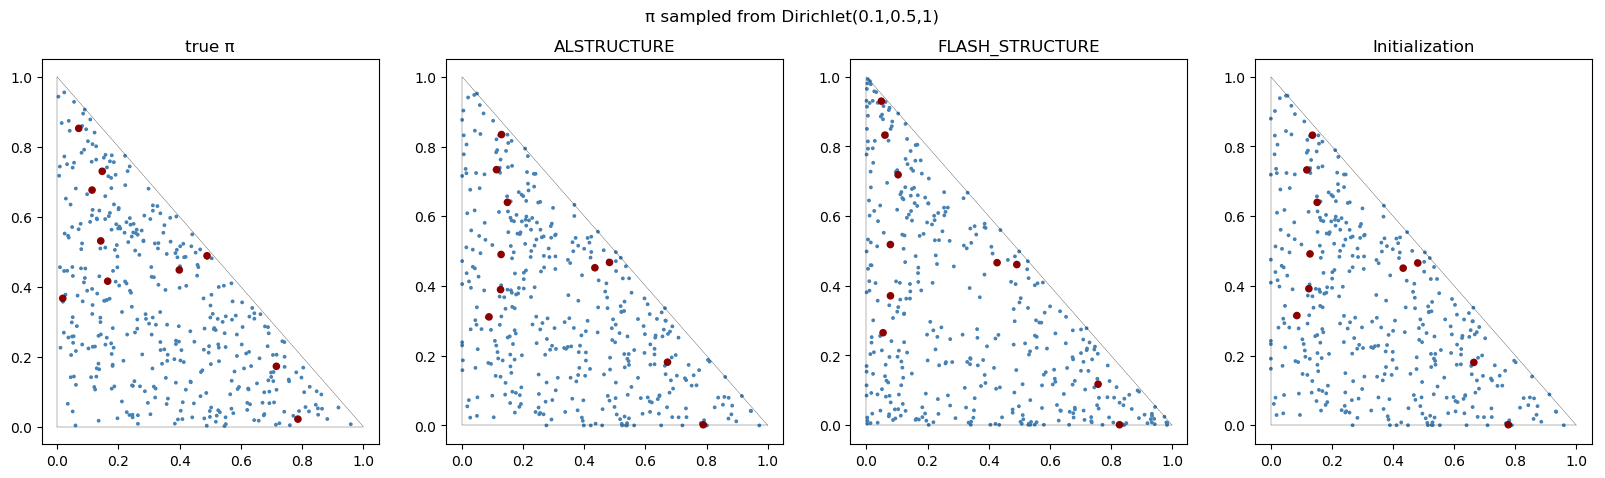

In [195]:
ind = n+1 - (1:10)
col = repeat([:steelblue],inner = n)
siz = 3 * ones(n)
siz[ind] = 20;
col[ind] = :darkred;

ax, fig = subplots(figsize = (20,5))
subplot(141)
PyPlot.scatter(Q_true[:,2],Q_true[:,3], s = siz, c = col);
PyPlot.plot((0,0),(0,1), c = :black, linewidth = 0.2);
PyPlot.plot((1,0),(0,0), c = :black, linewidth = 0.2);
PyPlot.plot((0,1),(1,0), c = :black, linewidth = 0.2);
PyPlot.title("true π")
subplot(142)
PyPlot.scatter(Q_als[:,1],Q_als[:,2], s = siz, c = col);
PyPlot.plot((0,0),(0,1), c = :black, linewidth = 0.2);
PyPlot.plot((1,0),(0,0), c = :black, linewidth = 0.2);
PyPlot.plot((0,1),(1,0), c = :black, linewidth = 0.2);
PyPlot.title("ALSTRUCTURE")
subplot(143)
PyPlot.scatter(π[:,1],π[:,2], s = siz, c = col);
PyPlot.plot((0,0),(0,1), c = :black, linewidth = 0.2);
PyPlot.plot((1,0),(0,0), c = :black, linewidth = 0.2);
PyPlot.plot((0,1),(1,0), c = :black, linewidth = 0.2);
PyPlot.title("FLASH_STRUCTURE")
subplot(144)
PyPlot.scatter(Q[:,1],Q[:,2], s = siz, c = col);
PyPlot.plot((0,0),(0,1), c = :black, linewidth = 0.2);
PyPlot.plot((1,0),(0,0), c = :black, linewidth = 0.2);
PyPlot.plot((0,1),(1,0), c = :black, linewidth = 0.2);
PyPlot.title("Initialization")

suptitle("π sampled from Dirichlet(0.1,0.5,1)");